In [1]:
import torch
# torch.backends.cudnn.benchmark = True
# torch.backends.cuda.matmul.allow_tf32 = True

print("Howdy")

Howdy


In [2]:
# from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

# image_encoder = CLIPVisionModelWithProjection.from_pretrained(
#     "h94/IP-Adapter", 
#     subfolder="models/image_encoder",
#     torch_dtype=torch.float16
# )

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers.utils import load_image

#device = "cpu"

# switch to "mps" for apple devices
pipe = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        #image_encoder=image_encoder,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16"
    )#.to(device)
#pipe = StableDiffusionXLPipeline.from_single_file("/home/kojo/Code/stable-diffusion-xl-base-1.0/sd_xl_base_1.0.safetensors")#.to(device)
#pipe.feature_extractor = None

pipe

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.36.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
# pipe.load_ip_adapter(
#         "/home/kojo/Code/IP-Adapter/",
#         subfolder="sdxl_models",
#         weight_name="ip-adapter-plus_sdxl_vit-h.safetensors",
#         image_encoder_folder="image_encoder",
#         local_files_only=True
#     )
pipe.load_ip_adapter(
        "h94/IP-Adapter",
        subfolder="sdxl_models",
        weight_name="ip-adapter-plus_sdxl_vit-h.safetensors",
        image_encoder_folder="models/image_encoder"
    )
#pipe.set_ip_adapter_scale(1.0)

In [5]:
pipe.load_lora_weights(
        "loras",
        weight_name="pkspif_nb_v1-2.safetensors",
        adapter_name="pokesprite"
    )
pipe.set_adapters(["pokesprite"], adapter_weights=[1.0])

pipe

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.36.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [15]:
pipe.vae.to(dtype=torch.float32)

pipe.enable_sequential_cpu_offload()

# # Offloading the weights to the CPU and only loading them on the GPU can reduce memory consumption to less than 3GB.
# pipe.enable_model_cpu_offload()

# # Tighter ordering of memory tensors.
# pipe.unet.to(memory_format=torch.channels_last)

# Decoding large batches of images with limited VRAM or batches with 32 images or more by decoding the batches of latents one image at a time.
pipe.vae.enable_slicing()

# Splitting the image into overlapping tiles, decoding the tiles, and then blending the outputs together to compose the final image. 
pipe.vae.enable_tiling()

pipe

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.36.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Inference Stuff

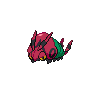

In [7]:
def get_embedding(image):
    image_features = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values
    with torch.no_grad():
        outputs = pipe.image_encoder(image_features, output_hidden_states=True)
        embedding = outputs.hidden_states[-2]
    
    return embedding

starting_image = load_image("./venipede_white.png")
starting_image

In [8]:
starting_embed = get_embedding(starting_image)
starting_embed.shape

torch.Size([1, 257, 1280])

In [9]:
starting_embed

tensor([[[ 0.3875, -0.0514,  0.4246,  ...,  0.3518, -0.0131, -0.6138],
         [-0.4265, -0.1078,  0.1486,  ...,  0.4238, -0.1138, -0.8179],
         [-0.2849, -0.2969,  0.6689,  ...,  0.2405,  0.0322, -0.4358],
         ...,
         [-0.1959,  0.2441, -0.1307,  ...,  0.2441,  0.2712, -0.0706],
         [ 0.6211,  0.3394,  0.0107,  ...,  0.2213,  0.1663,  0.3960],
         [-0.3989, -0.0140,  0.2413,  ...,  0.5107, -0.2083, -0.8760]]],
       dtype=torch.float16)

In [10]:
#starting_embeds = starting_embed
starting_embeds = torch.unsqueeze(starting_embed, 0)
starting_embeds.shape

torch.Size([1, 1, 257, 1280])

In [11]:
negative_embeds = torch.zeros_like(starting_embeds)
negative_embeds.shape

torch.Size([1, 1, 257, 1280])

In [12]:
combined_embeds = torch.cat([negative_embeds, starting_embeds], dim=0)
combined_embeds.shape

torch.Size([2, 1, 257, 1280])

In [16]:
image = pipe(
        prompt="Venipede, pokemon",
        #negative_prompt="blurry, fuzzy, 3d, realistic, photo",
        ip_adapter_image_embeds=[combined_embeds], 
        guidance_scale=7.5, 
        num_inference_steps=30
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: Input type (c10::Half) and bias type (float) should be the same

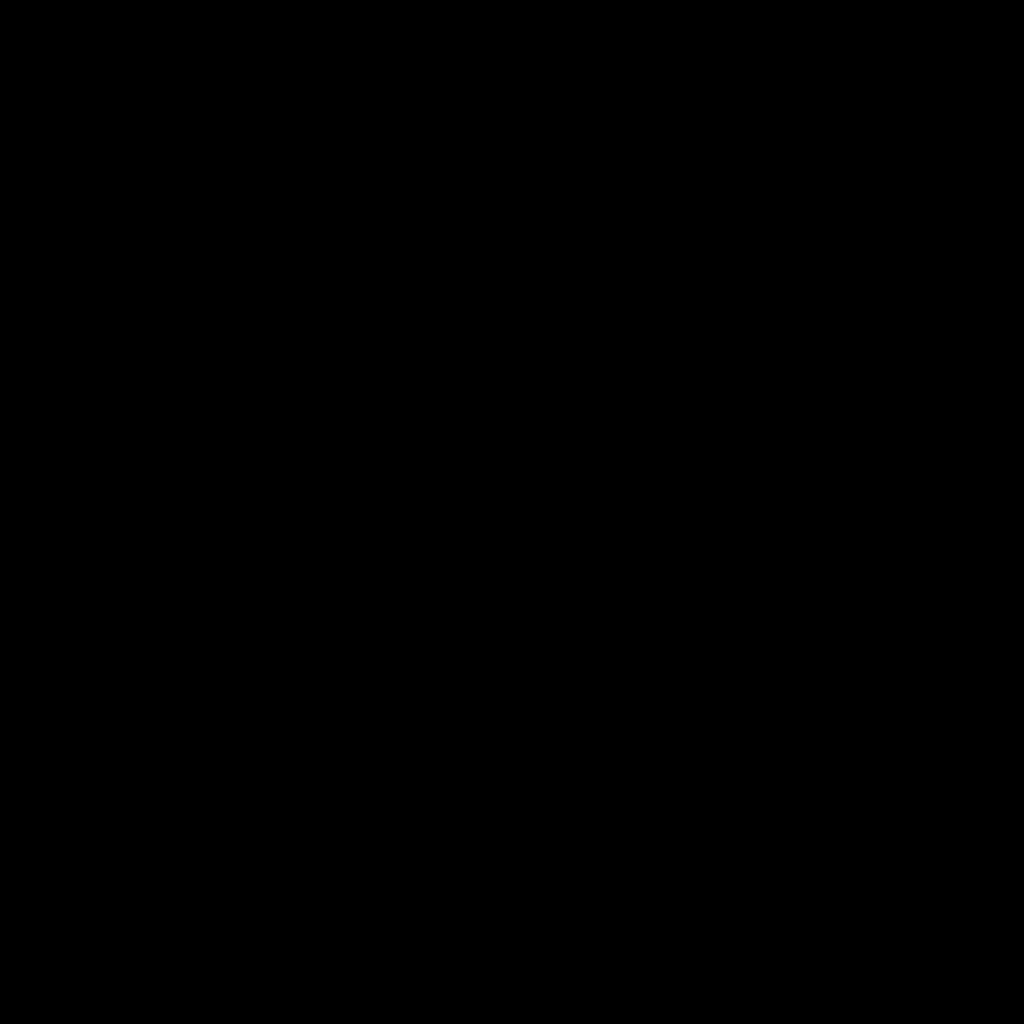

In [14]:
image